# Project 5: The Enron Dataset

Robert Lee

There are 146 people in the Enron Dataset, 21 features each, 18 POI (persons of interest) 

In [55]:
#!/usr/bin/python

import sys
import pickle

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import grid_search 
from time import time

from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary','total_stock_value','exercised_stock_options','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages','ratio_to_poi','ratio_from_poi','ratio_exercised']
# You will need to use more features, 8 existing features, 3 new ones I created

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

import pprint

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

I use 8 existing features, and create 3 more (the last 3)
features_list = ['poi','salary','total_stock_value','exercised_stock_options','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages','ratio_to_poi','ratio_from_poi','ratio_exercised']

In [2]:
features_list = ['poi','salary','total_stock_value','exercised_stock_options','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages','ratio_to_poi','ratio_from_poi','ratio_exercised']

Here is one entry in the dictionary, key: 'ALLEN PHILLIP K'

In [3]:
pprint.pprint(data_dict['ALLEN PHILLIP K'])

{'bonus': 4175000,
 'deferral_payments': 2869717,
 'deferred_income': -3081055,
 'director_fees': 'NaN',
 'email_address': 'phillip.allen@enron.com',
 'exercised_stock_options': 1729541,
 'expenses': 13868,
 'from_messages': 2195,
 'from_poi_to_this_person': 47,
 'from_this_person_to_poi': 65,
 'loan_advances': 'NaN',
 'long_term_incentive': 304805,
 'other': 152,
 'poi': False,
 'restricted_stock': 126027,
 'restricted_stock_deferred': -126027,
 'salary': 201955,
 'shared_receipt_with_poi': 1407,
 'to_messages': 2902,
 'total_payments': 4484442,
 'total_stock_value': 1729541}


Length of dictionary (number of people) and length of one of the entries == # of features

In [4]:
print len(data_dict)
print len(data_dict['ALLEN PHILLIP K'])

146
21


### Task 2: Remove outliers

Three of the "people" in the dictionary are not people, but bad data to be removed

"TOTAL" appears to be a summary statistic.
"TRAVEL AGENCY IN THE PARK" appears to be a contractor that was paid a sum of money.
"LOCKHART EUGENE E" has all NaN values. Harmless, but I go ahead and remove it.

I don't remove data outliers, because they are probably important data (the big shot executives making a lot of money and communicating a lot with each other).

In [5]:
data_dict.pop('TOTAL', 0)
data_dict.pop('TRAVEL AGENCY IN THE PAR', 0)
data_dict.pop('LOCKHART EUGENE E', 0)
print "Three entries popped"
len(data_dict)

Three entries popped


144

### I look for 'poi = TRUE to count the number of persons of interest

In [6]:
n=0
for each in data_dict:
    if data_dict[each]['poi']:
        n+=1
print n

18


### Task 3: Create new feature(s)
The 3 new features are:
ratio_exercised, ratio_to_poi, ratio_from_poi

(1) ratio_exercised = exercised_stock_options / total_stock_value
I created this feature to reflect how much stock the person exercised out of their total (from 0 to 1). I figured that people who were in on the scam might have exercised more of their options, knowing that it was a house of cards. On the other hand, a middle-class person who was not in on the scam might also exercise their options, given the high share price (honest desire to cash in).

(2) ratio_to_poi = from_this_person_to_poi / to_messages
Another 0 to 1 ratio. The absolute number of emails to a POI is less meaningful than the ratio of their messages to POI.

(3) ratio_to_poi = from_poi_to_this_person / from_messages
Another 0 to 1 ratio. The absolute number of emails from a POI is less meaningful than the ratio of messages from a POI.

I am aware that there might be data leakage issues regarding from_this_person_to_poi and from_poi_to_this_person, and thus any features derived from them, but it is not abssolutely clear that this is the case, so I will accept that they are OK features to use for purposes of this assignment.

I first eliminate NaN and bad values (any of numerator < 0, any denominator <= 0)

In [7]:
def new_feature(numerator,denominator):
    new_feature=[]

    for i in data_dict:
        if data_dict[i][numerator]=="NaN" or data_dict[i][denominator]=="NaN":
            new_feature.append("NaN")
        elif data_dict[i][numerator]<0 or data_dict[i][denominator]<=0:
            new_feature.append("NaN")
        else:
            new_feature.append(float(data_dict[i][numerator]) / data_dict[i][denominator])
    return new_feature

### create lists of new features
ratio_exercised=new_feature("exercised_stock_options","total_stock_value")
ratio_to_poi=new_feature("from_poi_to_this_person","to_messages")
ratio_from_poi=new_feature("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["ratio_exercised"] = ratio_exercised[count]
    data_dict[i]["ratio_to_poi"] = ratio_to_poi[count]
    data_dict[i]["ratio_from_poi"] = ratio_from_poi[count]
    count +=1

### store to my_dataset for easy export below
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)

labels, features = targetFeatureSplit(data)

# Plot new features to get a feel for them
## ratio_exercised

Ratio of stock options exercised is betwen 0 (none exercised) up to about 20%

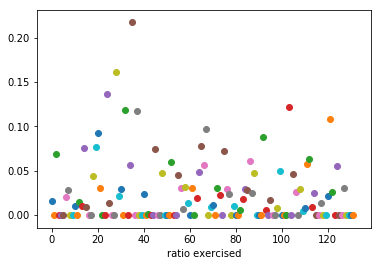

In [9]:
n=0
for point in data:
    ratio_exercised = point[8]
    plt.scatter( n, ratio_exercised )
    n+=1
plt.xlabel("ratio exercised")
plt.show()

## ratio_to_poi

Ratio of all emails sent to POI

Between 0 and 1.0.

The one 1.0 data point is suspiciously high, so I print one that point above the plot. This person was not a PIO, had a salary of 130K, had significant stock, sent 10 emails to POI, received 17 emails from POI, sent 17 total emails, and received 128 total emails. So this data point does not seem outlanding. In addition, since this feature is not in my top 5 best (see below), I am not too concerned with this 1.0 value.

[  0.00000000e+00   1.30724000e+05   2.28276800e+06   2.28276800e+06
   1.00000000e+01   1.70000000e+01   1.70000000e+01   1.28000000e+02
   7.81250000e-02   1.00000000e+00   1.00000000e+00]


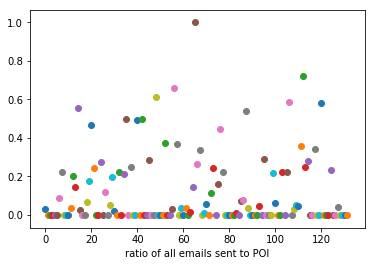

In [10]:
n=0
for point in data:
    ratio_to_poi  = point[9]
    if ratio_to_poi == 1.0:
        print point
    plt.scatter( n, ratio_to_poi )
    n+=1
plt.xlabel("ratio of all emails sent to POI")
plt.show()

## ratio_from_poi

Ratio of all emails from POI

Between 0 and 1.0.

There are a lot of 1.0 data points. So either the data is generally pretty bad, or else these 1.0 values are valid. I'll go with the latter assumption, though of course I could investigate more.

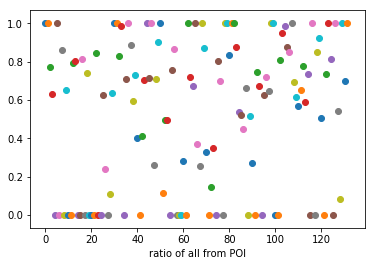

In [11]:
n=0
for point in data:
    ratio_from_poi  = point[10]
    plt.scatter( n, ratio_from_poi )
    n+=1
plt.xlabel("ratio of all from POI")
plt.show()

### Getting a sense of most highly correlated feature with SelectKBest()
I print out the best 5 features from two data points. I print the corresponding entire set of feature for each of these so I can compare and figure out which features these are (data does not have any dictionary keys)

The best 5 features, in order are:

salary

total_stock_value

exercised_stock_options

from_this_person_to_poi

ratio_from_poi

Only one of my new features, ratio_from_poi, made it into the top 5. I could go back and try to create better features, much less do PCA, but I won't change these for now.

# Cross Validation
At this point I won't use  StratifiedShuffleSplit but instead create three different test sizes: 0.1, 0.3, 0.5, using:

features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=X, random_state=42)

Since there are only 18 POIs, we can only go so small with the test size, before we don't get any POIs. 

I will use StratifiedShuffleSplit with 100 trials for cross-validation during GridSearch, with a test_size of 0.1. I don't think I can go any lower than this.

In [96]:
features_train1, features_test1, labels_train1, labels_test1 = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)
features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
features_train5, features_test5, labels_train5, labels_test5 = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=42)

# Trying NB with the above features and test sizes

In [97]:
def classify_NB(features_train, labels_train):
    
    ### your code goes here--should return a trained decision tree classifer
    
    clf = GaussianNB()
    clf.fit(features_train, labels_train)
    return clf

def class_run(features_train, labels_train, features_test, labels_test):
    clf = classify_NB(features_train, labels_train)
    pred = clf.predict(features_test)
    return {"Accuracy":accuracy_score(pred,labels_test),\
                          "Precision":precision_score(pred,labels_test),\
                          "Recall":recall_score(pred,labels_test),\
                          "F1":f1_score(pred,labels_test)}

In [98]:
print "all 11 features"
def print_it(title,input):
    print title
    answer = input
    for each in answer:
        print each," : ",answer[each]
    print

print_it("NB: 0.1 test size",class_run(features_train1, labels_train1, features_test1, labels_test1))
print_it("NB: 0.3 test size",class_run(features_train3, labels_train3, features_test3, labels_test3))
print_it("NB: 0.5 test size",class_run(features_train5, labels_train5, features_test5, labels_test5))

all 11 features
NB: 0.1 test size
Recall  :  0.5
F1  :  0.4
Precision  :  0.333333333333
Accuracy  :  0.785714285714

NB: 0.3 test size
Recall  :  0.75
F1  :  0.6
Precision  :  0.5
Accuracy  :  0.9

NB: 0.5 test size
Recall  :  0.333333333333
F1  :  0.4
Precision  :  0.5
Accuracy  :  0.863636363636



# Trying NB with different subsets of the features

features_list contains all 11 features (8 chosen, 3 new)

I create these subset feature lists as well

Each must contain the first feature, poi

features_old = the original 8

features_new = poi + the 3 new ones

features_first = poi + 1,2,3   ($ related)

features_second = poi + 4,5,6,7 (email related)

features_F = features_first + 'ratio_exercised' ($ related)

features_E = features_second + ratio_to_poi' + 'ratio_from_poi' (email related)

In [100]:
features_old = ['poi','salary','total_stock_value','exercised_stock_options','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages','ratio_to_poi','ratio_from_poi','ratio_exercised']
features_new = ['poi','ratio_to_poi','ratio_from_poi','ratio_exercised']
features_first = ['poi','salary','total_stock_value','exercised_stock_options']
features_second = ['poi','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages','ratio_to_poi','ratio_from_poi','ratio_exercised']
features_F = ['poi','salary','total_stock_value','exercised_stock_options','ratio_exercised']
features_E = ['poi','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages','ratio_to_poi','ratio_from_poi']

In [101]:
data = featureFormat(my_dataset, features_old, sort_keys = True)
labels, features = targetFeatureSplit(data)
features_train1, features_test1, labels_train1, labels_test1 = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)
features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
features_train5, features_test5, labels_train5, labels_test5 = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=42)

print "features_old = the original 8"
print
print_it("NB: 0.1 test size",class_run(features_train1, labels_train1, features_test1, labels_test1))
print_it("NB: 0.3 test size",class_run(features_train3, labels_train3, features_test3, labels_test3))
print_it("NB: 0.5 test size",class_run(features_train5, labels_train5, features_test5, labels_test5))

features_old = the original 8

NB: 0.1 test size
Recall  :  0.5
F1  :  0.4
Precision  :  0.333333333333
Accuracy  :  0.785714285714

NB: 0.3 test size
Recall  :  0.75
F1  :  0.6
Precision  :  0.5
Accuracy  :  0.9

NB: 0.5 test size
Recall  :  0.333333333333
F1  :  0.4
Precision  :  0.5
Accuracy  :  0.863636363636



In [102]:

data = featureFormat(my_dataset, features_new, sort_keys = True)
labels, features = targetFeatureSplit(data)
features_train1, features_test1, labels_train1, labels_test1 = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)
features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
features_train5, features_test5, labels_train5, labels_test5 = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=42)

print "features_new = 3 new features"
print
print_it("NB: 0.1 test size",class_run(features_train1, labels_train1, features_test1, labels_test1))
print_it("NB: 0.3 test size",class_run(features_train3, labels_train3, features_test3, labels_test3))
print_it("NB: 0.5 test size",class_run(features_train5, labels_train5, features_test5, labels_test5))

features_new = 3 new features

NB: 0.1 test size
Recall  :  0.0
F1  :  0.0
Precision  :  0.0
Accuracy  :  0.833333333333

NB: 0.3 test size
Recall  :  0.333333333333
F1  :  0.25
Precision  :  0.2
Accuracy  :  0.833333333333

NB: 0.5 test size
Recall  :  0.0
F1  :  0.0
Precision  :  0.0
Accuracy  :  0.830508474576



In [104]:
data = featureFormat(my_dataset, features_first, sort_keys = True)
labels, features = targetFeatureSplit(data)
features_train1, features_test1, labels_train1, labels_test1 = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)
features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
features_train5, features_test5, labels_train5, labels_test5 = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=42)

print "features_first = poi + 1,2,3   ($ related)"
print
print_it("NB: 0.1 test size",class_run(features_train1, labels_train1, features_test1, labels_test1))
print_it("NB: 0.3 test size",class_run(features_train3, labels_train3, features_test3, labels_test3))
print_it("NB: 0.5 test size",class_run(features_train5, labels_train5, features_test5, labels_test5))

features_first = poi + 1,2,3   ($ related)

NB: 0.1 test size
Recall  :  0.0
F1  :  0.0
Precision  :  0.0
Accuracy  :  0.846153846154

NB: 0.3 test size
Recall  :  0.0
F1  :  0.0
Precision  :  0.0
Accuracy  :  0.871794871795

NB: 0.5 test size
Recall  :  0.25
F1  :  0.181818181818
Precision  :  0.142857142857
Accuracy  :  0.861538461538



In [105]:
data = featureFormat(my_dataset, features_second, sort_keys = True)
labels, features = targetFeatureSplit(data)
features_train1, features_test1, labels_train1, labels_test1 = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)
features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
features_train5, features_test5, labels_train5, labels_test5 = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=42)

print "poi + 4,5,6,7 (email related)"
print
print_it("NB: 0.1 test size",class_run(features_train1, labels_train1, features_test1, labels_test1))
print_it("NB: 0.3 test size",class_run(features_train3, labels_train3, features_test3, labels_test3))
print_it("NB: 0.5 test size",class_run(features_train5, labels_train5, features_test5, labels_test5))

poi + 4,5,6,7 (email related)

NB: 0.1 test size
Recall  :  0.0
F1  :  0.0
Precision  :  0.0
Accuracy  :  0.833333333333

NB: 0.3 test size
Recall  :  0.272727272727
F1  :  0.352941176471
Precision  :  0.5
Accuracy  :  0.694444444444

NB: 0.5 test size
Recall  :  0.5
F1  :  0.444444444444
Precision  :  0.4
Accuracy  :  0.833333333333



### Above feature investigations
We are getting better scores from using both $ and email related data, so I am simply going to use all 11 features (including the 3 new ones) for the next set of def DTC and KNN classifiers

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Trying DecisionTreeClassifier() with default arguments
## Worse results than NB()

In [80]:
def classify_DTC(features_train, labels_train):
    
    ### your code goes here--should return a trained decision tree classifer
    
    clf = DecisionTreeClassifier()
    clf.fit(features_train, labels_train)
    return clf

def class_run_DTC(features_train, labels_train, features_test, labels_test):
    clf = classify_DTC(features_train, labels_train)
    pred = clf.predict(features_test)
    return {"Accuracy":accuracy_score(pred,labels_test),\
                          "Precision":precision_score(pred,labels_test),\
                          "Recall":recall_score(pred,labels_test),\
                          "F1":f1_score(pred,labels_test)}

labels, features = targetFeatureSplit(data)
features_train1, features_test1, labels_train1, labels_test1 = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)
features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
features_train5, features_test5, labels_train5, labels_test5 = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=42)

print "All 11 features, DTC"
print
print_it("DTC: 0.1 test size",class_run_DTC(features_train1, labels_train1, features_test1, labels_test1))
print_it("DTC: 0.3 test size",class_run_DTC(features_train3, labels_train3, features_test3, labels_test3))
print_it("DTC: 0.5 test size",class_run_DTC(features_train5, labels_train5, features_test5, labels_test5))

All 11 features, DTC

DTC: 0.1 test size
Recall  :  0.333333333333
F1  :  0.333333333333
Precision  :  0.333333333333
Accuracy  :  0.714285714286

DTC: 0.3 test size
Recall  :  0.166666666667
F1  :  0.166666666667
Precision  :  0.166666666667
Accuracy  :  0.75

DTC: 0.5 test size
Recall  :  0.1
F1  :  0.125
Precision  :  0.166666666667
Accuracy  :  0.787878787879



# Trying KNN() with k=5
## Similar results to NB() at test size 0.1 and 0.5

In [90]:
def classify_KNN(features_train, labels_train):
    
    ### your code goes here--should return a trained decision tree classifer
    
    clf = KNeighborsClassifier(3)
    clf.fit(features_train, labels_train)
    return clf

def class_run_KNN(features_train, labels_train, features_test, labels_test):
    clf = classify_KNN(features_train, labels_train)
    pred = clf.predict(features_test)
    return {"Accuracy":accuracy_score(pred,labels_test),\
                          "Precision":precision_score(pred,labels_test),\
                          "Recall":recall_score(pred,labels_test),\
                          "F1":f1_score(pred,labels_test)}

labels, features = targetFeatureSplit(data)
features_train1, features_test1, labels_train1, labels_test1 = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)
features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
features_train5, features_test5, labels_train5, labels_test5 = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=42)

print "All 11 features, KNN, k=5"
print
print_it("KNN: 0.1 test size",class_run_KNN(features_train1, labels_train1, features_test1, labels_test1))
print_it("KNN: 0.3 test size",class_run_KNN(features_train3, labels_train3, features_test3, labels_test3))
print_it("KNN: 0.5 test size",class_run_KNN(features_train5, labels_train5, features_test5, labels_test5))

All 11 features, KNN, k=5

KNN: 0.1 test size
Recall  :  1.0
F1  :  0.5
Precision  :  0.333333333333
Accuracy  :  0.857142857143

KNN: 0.3 test size
Recall  :  0.0
F1  :  0.0
Precision  :  0.0
Accuracy  :  0.85

KNN: 0.5 test size
Recall  :  0.6
F1  :  0.545454545455
Precision  :  0.5
Accuracy  :  0.924242424242



### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

## I do a grid search on KNN, evaluating by F1 score, using all 11 features

In [91]:
knn =  KNeighborsClassifier()
scaler = MinMaxScaler()
sss = StratifiedShuffleSplit(n_splits = 100, test_size=0.1,random_state=42)

pipe = Pipeline(steps=[('scaling', scaler), ("knn", knn)])

param_grid = {"knn__n_neighbors": [1, 3, 5, 8, 10, 12, 14],
              "knn__algorithm": ["auto","ball_tree", "kd_tree", "brute"],
              "knn__leaf_size": range(3,10,1),
              "knn__p": [1,2]
             }

knnclf = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
knnclf.fit(features, labels)
bestknn = knnclf.best_estimator_
bestparams = knnclf.best_params_
print "Best KNN"
print bestknn
print bestparams

Best KNN
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])
{'knn__leaf_size': 3, 'knn__algorithm': 'auto', 'knn__n_neighbors': 1, 'knn__p': 2}


In [92]:
best = KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
best.fit(features_train1, labels_train1)
pred = best.predict(features_test1)
print "KNN grid: accuracy, precision, recall, F1"
print accuracy_score(pred,labels_test1)
print precision_score(pred,labels_test1)
print recall_score(pred,labels_test1)
print f1_score(pred,labels_test1)

KNN grid: accuracy, precision, recall, F1
0.785714285714
0.333333333333
0.5
0.4


The resulting best KNN classified under these parameters is:

KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
           
And the scores are:

KNN grid: accuracy, precision, recall, F1

0.857142857143 accuracy

0.333333333333 precision

1.0 recall

0.5 F1

0.5 is not a bad F1 score. I could likely do better if I played around with the grid search parameters a bit, but this is not bad.

## Dumping classifer, dataset, and feature_list to .pkl

In [109]:
CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)
        
dump_classifier_and_data(bestknn, data_dict, features_list)

In [110]:
## Checking the written files

In [111]:
with open("my_classifier.pkl", "r") as file:
    clf = pickle.load(file)
print clf

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])


In [112]:
with open("my_dataset.pkl", "r") as file:
    data = pickle.load(file)
for person in data:
    print person, data[person]
    break

METTS MARK {'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'loan_advances': 'NaN', 'bonus': 600000, 'email_address': 'mark.metts@enron.com', 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'shared_receipt_with_poi': 702, 'long_term_incentive': 'NaN', 'exercised_stock_options': 'NaN', 'from_messages': 29, 'other': 1740, 'from_poi_to_this_person': 38, 'from_this_person_to_poi': 1, 'poi': False, 'deferred_income': 'NaN', 'expenses': 94299, 'restricted_stock': 585062, 'director_fees': 'NaN'}


In [113]:
with open("my_feature_list.pkl", "r") as file:
    features = pickle.load(file)
print features

['poi', 'salary', 'total_stock_value', 'exercised_stock_options', 'from_poi_to_this_person', 'from_this_person_to_poi', 'from_messages', 'to_messages', 'ratio_to_poi', 'ratio_from_poi', 'ratio_exercised']
